# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:2'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


# Test 1

In [3]:
image_path:str = "test_images/1.T.jpg"
prompt :str = "<image>\nDescribe this picture concisely."

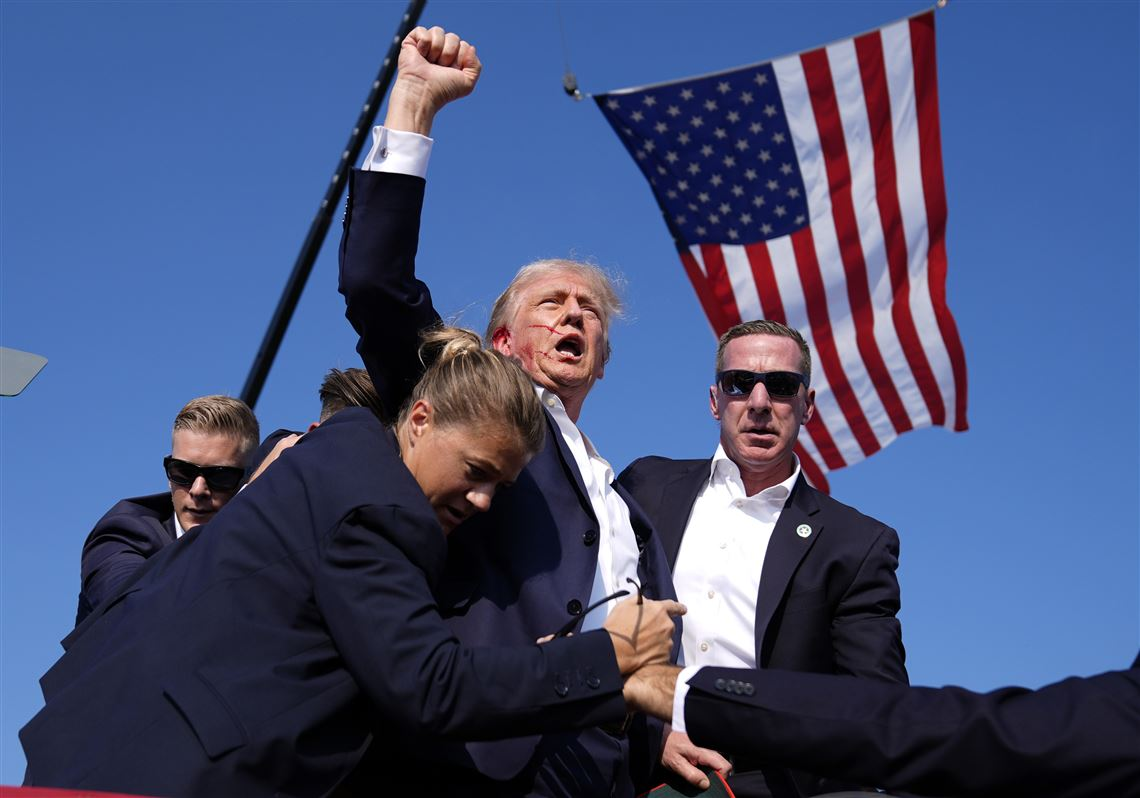

In [8]:
image = Image.open(image_path)
image

In [5]:
cur_conv = conversation.conv_qwen2_5.copy()
cur_image = Image.open(image_path)
image = image_processor(cur_image, return_tensors='pt')['pixel_values']
cur_conv.append_message(['USER',(prompt,cur_image)])
text = cur_conv.get_prompt()
text += "\n<|im_start|>assistant\n"
input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
input_ids = input_ids.unsqueeze(0)
attention_mask = torch.ones_like(input_ids)
labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

image = image.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)
output_ids = model.generate(
    inputs=input_ids,                  # 输入 tokens
    max_length=1024,                      
    num_return_sequences=1,             # 返回生成的序列数
    temperature=0.7,                    # 控制生成的多样性
    top_k=50,                           # 限制最高概率的 K 个标记
    top_p=0.95,                         # 过滤累积概率小于 P 的标记
    do_sample=True,                     # 使用采样生成（而非贪心算法）
    images=image,
    attention_mask=attention_mask,
    labels=labels,
    use_cache=True,
)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Generated text:       {generated_text}")

Generated text:       The image features a group of people gathered together with flags, and holding a man of men and women in blue people wearing president and women dressed to welcome people wearing in business in a political, one man wearing an outdoor people wearing suits, including a man dressed together outdoors on a flag in a political, some people in a politician and women, one man, some of varying an outdoor in a man in a political, possibly in a political, some of whom a group of whom a flag in a political dressed in a political in a flag Donald in a political in a political Barack in a political in a political in a political in a political Donald in a political Donald in a political Donald  there is holding an event a political in a political campaign campaign rally speech speech rally speech rally  the a political speech at a political speech at a political  The a political speech at a rally, three speech at a man, one man, one man giving an American speech meeting at a fla

In [6]:
image_path:str = "test_images/1.T.jpg"
prompt :str = "<image>\nIs there a flag in the picture? Provide a clear yes or no answer."

In [7]:
cur_conv = conversation.conv_qwen2_5.copy()
cur_image = Image.open(image_path)
image = image_processor(cur_image, return_tensors='pt')['pixel_values']
cur_conv.append_message(['USER',(prompt,cur_image)])
text = cur_conv.get_prompt()
text += "\n<|im_start|>assistant\n"
input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
input_ids = input_ids.unsqueeze(0)
attention_mask = torch.ones_like(input_ids)
labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

image = image.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)
output_ids = model.generate(
    inputs=input_ids,                  # 输入 tokens
    max_length=1024,                      
    num_return_sequences=1,             # 返回生成的序列数
    temperature=0.7,                    # 控制生成的多样性
    top_k=50,                           # 限制最高概率的 K 个标记
    top_p=0.95,                         # 过滤累积概率小于 P 的标记
    do_sample=True,                     # 使用采样生成（而非贪心算法）
    images=image,
    attention_mask=attention_mask,
    labels=labels,
    use_cache=True,
)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Generated text:       {generated_text}")

Generated text:       Yes, there is a flag in the image, there is present in the picture features a national, there is a flag in the picture, the image an American an American an American an American a American an American a American flag flying, the picture, a American flag the picture an American flag a American flag the picture, a American flag an American flag of the picture an American flag, there a American with the picture raised the the the picture with the scene, and one with the the song of the, the of the featuring, of the of the the is displayed the on the is visible of the scene is displayed the of the the is ho the the on the featuring, and it the of the of the is shown, and the a of the the is displayed of the featuring the is ho of the is displayed in the of the on the featuring the is raised, of the. the is ho of the featuring is in the. The featuring the featuring the. of the featuring a with the featuring a of the the featuring a featuring a of the featuring a of the

# Test2

In [9]:
image_path:str = "test_images/2.G.jpg"
prompt :str = "<image>\nDescribe this picture concisely."

In [10]:
cur_conv = conversation.conv_qwen2_5.copy()
cur_image = Image.open(image_path)
image = image_processor(cur_image, return_tensors='pt')['pixel_values']
cur_conv.append_message(['USER',(prompt,cur_image)])
text = cur_conv.get_prompt()
text += "\n<|im_start|>assistant\n"
input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
input_ids = input_ids.unsqueeze(0)
attention_mask = torch.ones_like(input_ids)
labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

image = image.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)
output_ids = model.generate(
    inputs=input_ids,                  # 输入 tokens
    max_length=1024,                      
    num_return_sequences=1,             # 返回生成的序列数
    temperature=0.7,                    # 控制生成的多样性
    top_k=50,                           # 限制最高概率的 K 个标记
    top_p=0.95,                         # 过滤累积概率小于 P 的标记
    do_sample=True,                     # 使用采样生成（而非贪心算法）
    images=image,
    attention_mask=attention_mask,
    labels=labels,
    use_cache=True,
)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Generated text:       {generated_text}")

Generated text:       The image captures a beautiful the stunning a stunning scene features the iconic views a long of a long view showcases the iconic Golden view of the iconic San Golden red Golden Gate Bridge, red Golden Gate Bridge Bridge Bridge Bridge Bridge in San Bridge stretching over the Golden Gate Bridge, B in San Bridge spanning suspension str suspension suspension suspension suspension over the Golden Gate, an engineering in San Bridge connecting in San Francisco in San Francisco in San Francisco Bridge, a suspension, spanning suspension in San Francisco Bridge, a Bay in San Francisco Bridge spanning in San Francisco Bridge stretching across—the Bridge rising in San Francisco in San Francisco Bridge in San Francisco in San Francisco, connecting, with the Francisco, connecting Bridge in red in San Francisco Bridge in San Francisco Bay in San Francisco Dam in San Francisco Bridge in both San Francisco Bridge, a Francisco, connecting in red Francisco's Golden Francisco, USA B